In [1]:
import os # ADDED THIS LINE
os.environ['MUJOCO_GL'] = 'egl'  # ADDED THIS LINE

import jax
import jax.numpy as jnp
import mujoco
from mujoco import mjx
from matplotlib import pyplot as plt
import numpy as np

from sysidmjx.core import generate_loss_train_functions, get_batch
from sysidmjx.assets.single_motor.dataloader.single_joint import data_load

class PARAMS:
    SEED = jax.random.PRNGKey(0)

    class DATASET:
        PATH = "datasets/generated/test.csv"
        DT = 0.001
        sim_every = 10
        ACTION_DIM = 1
        motor_id =3
        num_lags=5

    class SIM:
        PATH = "assets/single_motor/model/single_motor_best.xml"

        INTEGRATOR = mujoco.mjtIntegrator.mjINT_RK4
        ITERATIONS = 1000
        # INTEGRATOR = mujoco.mjtIntegrator.mjINT_EULER
        # INTEGRATOR = mujoco.mjtIntegrator.mjINT_RK4
        # ITERATIONS = 1

    class MODEL:
        NUM_HIST_LAGS = 2

Failed to import warp: No module named 'warp'
Failed to import mujoco_warp: No module named 'warp'


W1125 15:09:13.866972  302440 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1125 15:09:13.870918  302351 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


# For video

In [2]:
!pip install imageio
!pip install imageio[ffmpeg]
import imageio

/home/carlijn/miniconda3/lib/python3.13/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


# Upload data

In [2]:
dataset, df =data_load(
    data_path=PARAMS.DATASET.PATH,
    motor_id=PARAMS.DATASET.motor_id,
    num_lags=PARAMS.DATASET.num_lags,
)

In [3]:
mj_model = mujoco.MjModel.from_xml_path(PARAMS.SIM.PATH)
mj_model.opt.timestep = PARAMS.DATASET.DT * PARAMS.DATASET.sim_every
mj_model.opt.iterations = PARAMS.SIM.ITERATIONS
mj_model.opt.integrator = PARAMS.SIM.INTEGRATOR
mj_data = mujoco.MjData(mj_model)

mjx_model = mjx.put_model(mj_model)
mjx_data = mjx.put_data(mj_model, mj_data)
print(f"integrator:{mj_model.opt.integrator}")
print(f"timestep:{mj_model.opt.timestep}")
print(f"iterations:{mj_model.opt.iterations}")

integrator:1
timestep:0.01
iterations:1000


# Simulate every 10th (for speed up)

In [ ]:
# Setup video writer with desired fps
video_filename = "simulation_best_motor_model.mp4"
writer = imageio.get_writer(video_filename, fps=100)

# Initialize Mujoco renderer 
renderer = mujoco.Renderer(mj_model)

# Define the ideal motor model for control input
def ideal_model(qact, qpos, qvel):
    # Control law: Proportional-Derivative controller for ideal behavior
    tau = 20 * (qact - qpos) - (1) * qvel  # Control torque
    fric = 0  # Friction model (set to 0 for simplicity)
    return tau - fric

# Initialize the model's state with the first frame of real data
mj_data.qpos[:] = df[["qpos"]].values[0]
mj_data.qvel[:] = df[["qvel"]].values[0]
mujoco.mj_step(mj_model, mj_data)

# Initialize dictionary to store simulation data
data_hist = {
    "qpos": [],
    "qvel": [],
    "ctrl": [],
    "qdes": [],
    "qtau": [],
    "time": [],
}

# Define the length of the simulation
LEN = df[["qpos"]].values.shape[0] // PARAMS.DATASET.sim_every

# Simulation loop
for i in range(LEN):
    # Get the control action for the current time step
    action = df[["qact"]].values[::PARAMS.DATASET.sim_every][i]

    # Update control inputs based on the ideal model
    mj_data.ctrl[:] = ideal_model(action, mj_data.qpos, mj_data.qvel)
    
    # Store the state variables at this time step
    data_hist["qvel"].append(mj_data.qvel.copy())
    data_hist["qdes"].append(action)
    data_hist["qpos"].append(mj_data.qpos.copy())
    data_hist["qtau"].append(mj_data.qfrc_actuator.copy())
    data_hist["time"].append(mj_data.time)
    
    # Perform a simulation step
    mujoco.mj_step(mj_model, mj_data)

    # Update the renderer and append the rendered frame to the video
    # renderer.update_scene(mj_data, 1)
    # pixels = renderer.render()
    # writer.append_data(pixels)

# Close the video writer to save the video file
writer.close()


/home/carlijn/miniconda3/lib/python3.13/subprocess.py:1902: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(


NameError: name 'data_hist' is not defined

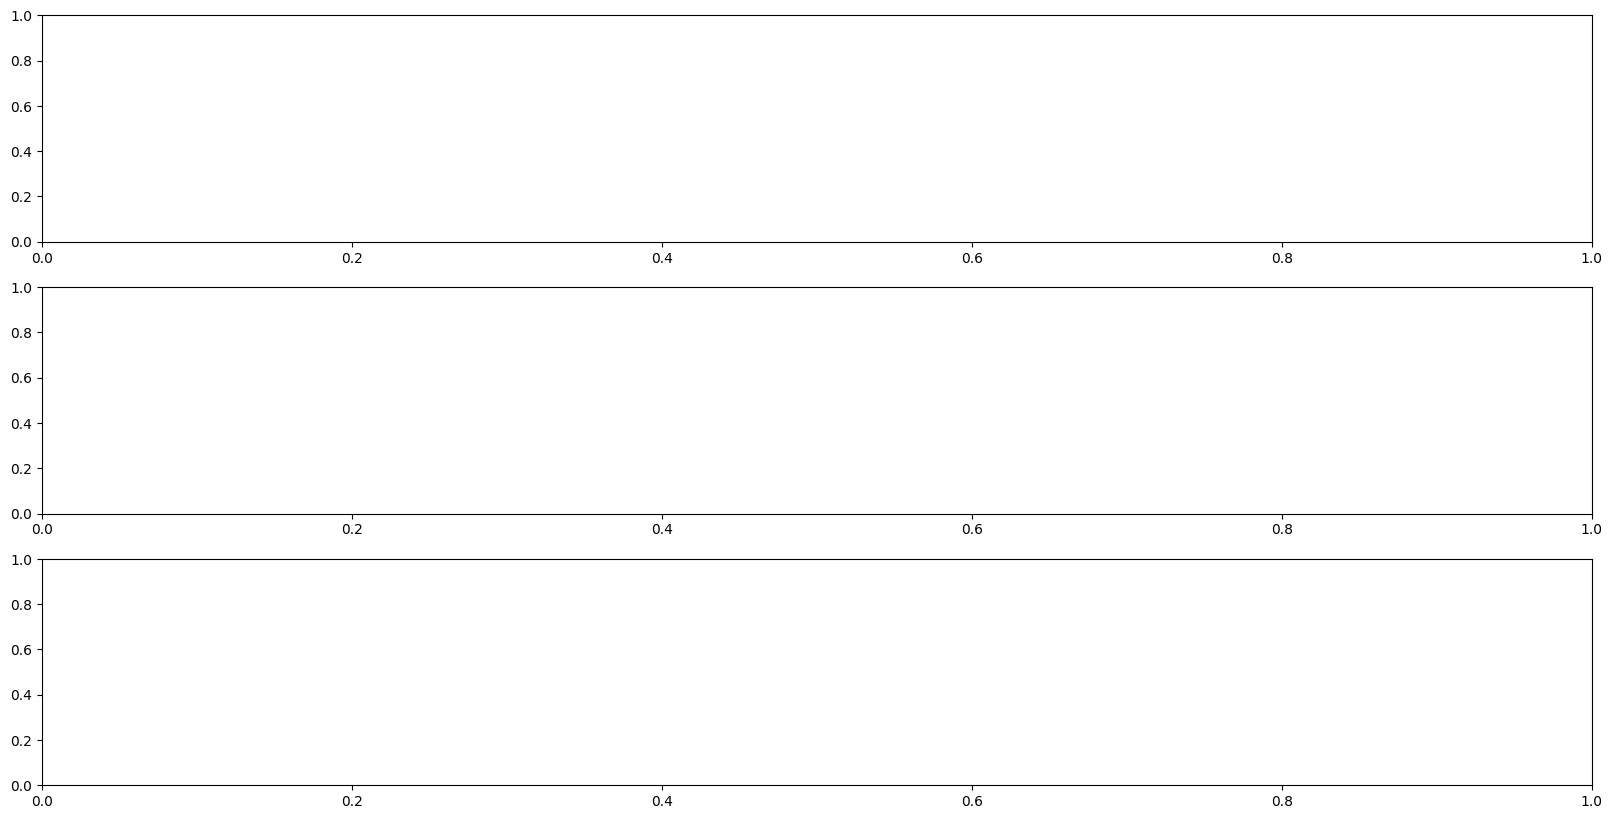

In [4]:
# Create a figure with 3 subplots
fig, ax = plt.subplots(nrows=3, figsize=(20, 10))

# Plot simulated, real, and desired qpos on the first subplot
ax[0].plot(data_hist["qpos"], label="Simulated qpos")
ax[0].plot(df["qpos"].values[::PARAMS.DATASET.sim_every], label="Real qpos")
ax[0].plot(df["qact"].values[::PARAMS.DATASET.sim_every], label="Desired qpos")
ax[0].legend()

# Plot simulated and real qvel on the second subplot with adjusted transparency
ax[1].plot(data_hist["qvel"], alpha=0.8, label="Simulated qvel")
ax[1].plot(df["qvel"].values[::PARAMS.DATASET.sim_every], label="Real qvel", alpha=0.4)
ax[1].legend()

# Plot zoomed-in version of qpos and compare with real data on the third subplot
ax[2].plot(data_hist["qpos"][:500], label="Simulated qpos", alpha=1)
ax[2].plot(df["qpos"].values[::PARAMS.DATASET.sim_every][:500], "--", alpha=1, label="Real qpos")
ax[2].plot(df["qact"].values[::PARAMS.DATASET.sim_every][:500], alpha=1, label="Desired qpos")
ax[2].legend()

# Show the plot
plt.show()
